# LunarLander-v2 with Q-learning/SARSA

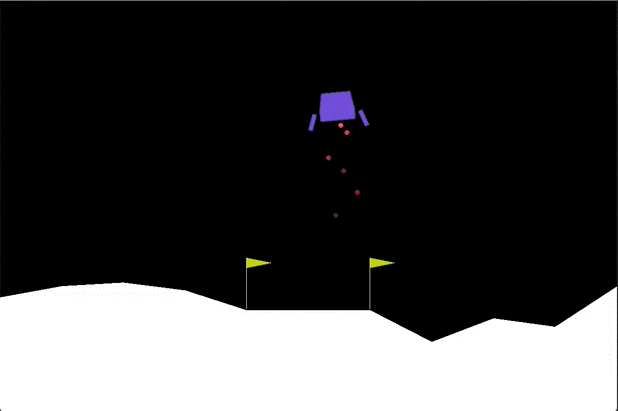

In [ ]:
import sys
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### Create an environment

In [ ]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)


### Random agent (initial)

In [ ]:
state = env.reset()
score = 0
for t in range(200):
    action = env.action_space.sample()
    env.render()
    next_state, reward, terminate, truncated, info = env.step(action)
    score += reward
print('Final score:', score)
env.close()

### Explore state (observation) space

In [ ]:
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

### Generate some samples from the state space 

In [ ]:
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

### Explore the action space and generate samples

In [ ]:
print("Action space:", env.action_space)

print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

### Create uniform grid

In [ ]:
def create_uniform_grid(low, high, bins=(10, 10)):
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    print("Uniform grid: [<low>, <high>] / <bins> => <splits>")
    for l, h, b, splits in zip(low, high, bins, grid):
        print("    [{}, {}] / {} => {}".format(l, h, b, splits))
    return grid


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  # [test]

### Discretizer function

In [ ]:
def discretize(sample, grid):
    return list(np.digitize(s, g).astype(int) for s, g in zip(sample, grid))  # apply along each dimension


# Test with a simple grid and some samples
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")

### Create a grid to discretize the state space

In [ ]:
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))
state_grid

### Q-learning Agent

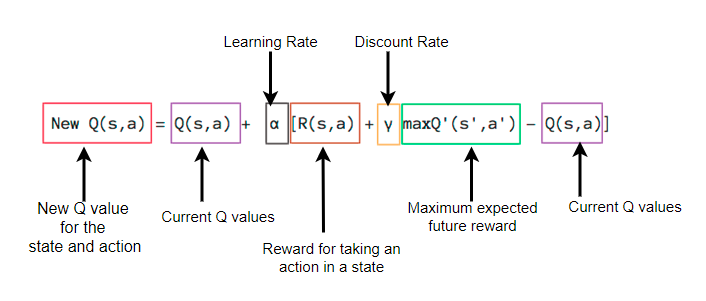

In [ ]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            action = np.argmax(self.q_table[state])
        else:
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

    
q_agent = QLearningAgent(env, state_grid)

### SARSA Agent

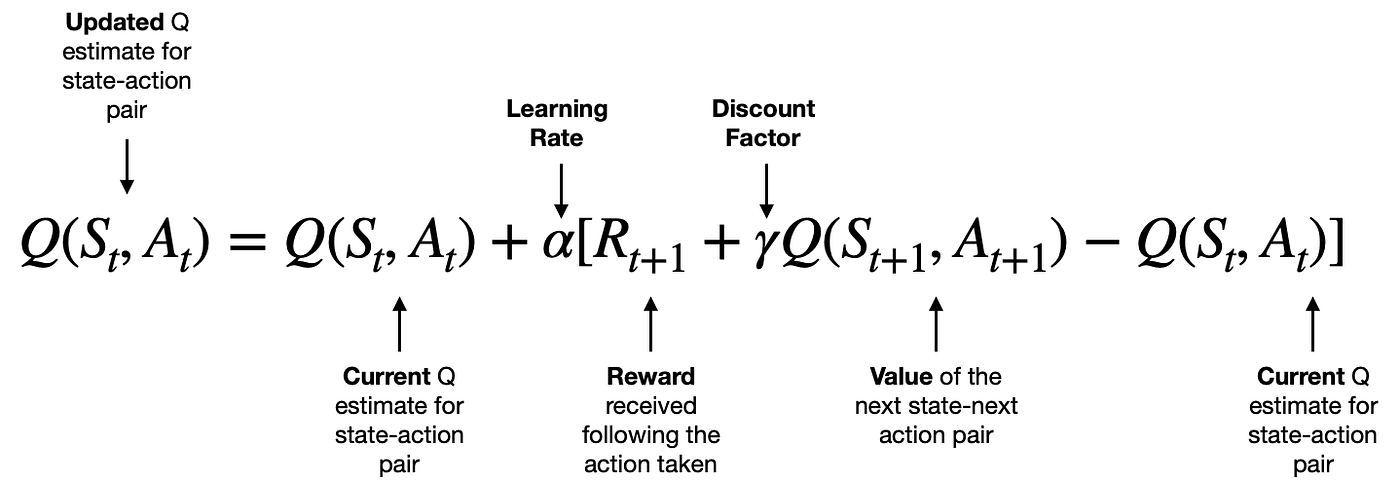

In [ ]:
class SARSAAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            action = np.argmax(self.q_table[state])
        else:
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * self.q_table[state+(action,)] - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

    
q_agent = SARSAAgent(env, state_grid)

In [ ]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            next_state, reward, terminate, truncated, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()

    return scores

scores = run(q_agent, env)

### Plot scores obtained per episode

In [ ]:
plt.plot(scores) 
plt.title("Scores")

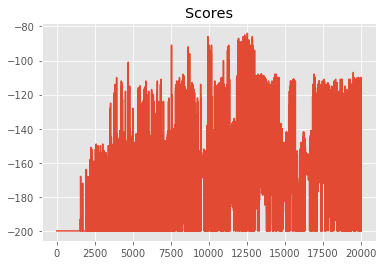

If the scores are noisy, it might be difficult to tell whether the agent is actually learning. To find the underlying trend, we can plot a rolling mean of the scores. Let's write a convenience function to plot both raw scores as well as a rolling mean.

In [ ]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

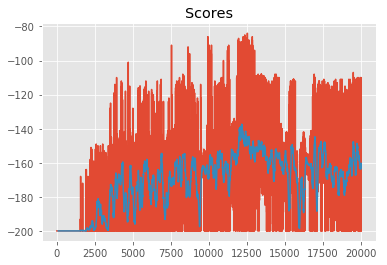

In [ ]:
# Run in test mode and analyze scores obtained
test_scores = run(q_agent, env, num_episodes=100, mode='test')
print("[TEST] Completed {} episodes with avg. score = {}".format(len(test_scores), np.mean(test_scores)))
_ = plot_scores(test_scores)

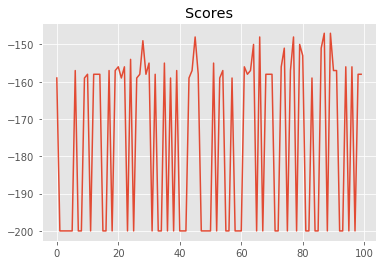